In [ ]:
Data Collection & Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load and Explore Data
def load_crypto_data(filepath):
    """Load cryptocurrency historical data"""
    df = pd.read_csv(filepath)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    return df

# Step 2: Handle Missing Values
def handle_missing_values(df):
    """Handle missing values using forward fill and interpolation"""
    # Forward fill for short gaps
    df = df.fillna(method='ffill', limit=5)
    # Linear interpolation for remaining gaps
    df = df.interpolate(method='linear', limit_direction='both')
    # Drop remaining NaN rows
    df = df.dropna()
    return df

# Step 3: Data Cleaning
def clean_data(df):
    """Remove outliers and inconsistencies"""
    # Remove rows where open, high, low, close don't follow logical order
    df = df[(df['low'] <= df['high']) &
            (df['open'] >= df['low']) &
            (df['open'] <= df['high']) &
            (df['close'] >= df['low']) &
            (df['close'] <= df['high'])].copy()

    # Remove zero or negative prices
    df = df[(df['open'] > 0) & (df['high'] > 0) &
            (df['low'] > 0) & (df['close'] > 0)].copy()

    return df

# Step 4: Normalization
def normalize_features(df, features_to_normalize):
    """Normalize numerical features"""
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])
    return df, scaler


Feature Engineering

In [2]:
def engineer_features(df):
    """Create advanced features for volatility prediction"""

    # 1. VOLATILITY INDICATORS
    # Intra-day volatility (High-Low range)
    df['intraday_volatility'] = (df['high'] - df['low']) / df['open']

    # Rolling volatility (Standard deviation of returns)
    df['returns'] = df['close'].pct_change()
    df['rolling_volatility_7'] = df['returns'].rolling(window=7).std()
    df['rolling_volatility_14'] = df['returns'].rolling(window=14).std()
    df['rolling_volatility_30'] = df['returns'].rolling(window=30).std()

    # 2. MOVING AVERAGES
    df['MA_7'] = df['close'].rolling(window=7).mean()
    df['MA_14'] = df['close'].rolling(window=14).mean()
    df['MA_30'] = df['close'].rolling(window=30).mean()

    # Price momentum
    df['momentum_7'] = df['close'] - df['MA_7']
    df['momentum_14'] = df['close'] - df['MA_14']

    # 3. LIQUIDITY INDICATORS
    df['volume_ma_7'] = df['volume'].rolling(window=7).mean()
    df['liquidity_ratio'] = df['volume'] / df['market_cap']
    df['volume_volatility'] = df['volume'].rolling(window=7).std() / df['volume_ma_7']

    # 4. BOLLINGER BANDS
    df['bb_upper'] = df['MA_14'] + 2 * df['rolling_volatility_14']
    df['bb_lower'] = df['MA_14'] - 2 * df['rolling_volatility_14']
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['MA_14']

    # 5. ATR (Average True Range)
    df['tr'] = np.maximum(
        df['high'] - df['low'],
        np.maximum(
            abs(df['high'] - df['close'].shift(1)),
            abs(df['low'] - df['close'].shift(1))
        )
    )
    df['atr_14'] = df['tr'].rolling(window=14).mean()
    df['atr_percent'] = df['atr_14'] / df['close']

    # 6. RSI (Relative Strength Index)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # 7. PRICE CHANGE FEATURES
    df['price_change_1d'] = df['close'].pct_change()
    df['price_change_7d'] = df['close'].pct_change(7)
    df['price_change_30d'] = df['close'].pct_change(30)

    # 8. TARGET VARIABLE: Next Day Volatility (what we predict)
    df['target_volatility'] = df['rolling_volatility_7'].shift(-1)

    # Drop NaN rows created by feature engineering
    df = df.dropna()

    return df


Exploratory Data Analysis (EDA)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def perform_eda(df):
    """Generate comprehensive EDA report"""

    # Set style
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(20, 16))

    # 1. Price Distribution
    ax1 = plt.subplot(3, 3, 1)
    df['close'].hist(bins=50, edgecolor='black')
    ax1.set_title('Distribution of Close Prices')

    # 2. Volatility Distribution
    ax2 = plt.subplot(3, 3, 2)
    df['rolling_volatility_14'].hist(bins=50, edgecolor='black', color='orange')
    ax2.set_title('Distribution of Rolling Volatility')

    # 3. Time Series of Close Price
    ax3 = plt.subplot(3, 3, 3)
    ax3.plot(df['date'], df['close'], linewidth=0.8)
    ax3.set_title('Close Price Over Time')
    ax3.set_xlabel('Date')

    # 4. Volume Trends
    ax4 = plt.subplot(3, 3, 4)
    ax4.bar(df['date'], df['volume'], width=1, alpha=0.6, color='green')
    ax4.set_title('Trading Volume Over Time')

    # 5. Correlation Heatmap
    ax5 = plt.subplot(3, 3, 5)
    features_for_corr = ['open', 'high', 'low', 'close', 'volume',
                         'rolling_volatility_14', 'atr_percent', 'rsi']
    corr_matrix = df[features_for_corr].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax5,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    ax5.set_title('Feature Correlation Matrix')

    # 6. Returns Distribution
    ax6 = plt.subplot(3, 3, 6)
    df['returns'].hist(bins=50, edgecolor='black', color='red')
    ax6.set_title('Distribution of Daily Returns')

    # 7. Volatility vs Volume
    ax7 = plt.subplot(3, 3, 7)
    ax7.scatter(df['volume'], df['rolling_volatility_14'], alpha=0.5, s=10)
    ax7.set_title('Volume vs Volatility')
    ax7.set_xlabel('Volume')
    ax7.set_ylabel('Volatility')

    # 8. Moving Averages
    ax8 = plt.subplot(3, 3, 8)
    ax8.plot(df['date'], df['close'], label='Close', linewidth=1, alpha=0.7)
    ax8.plot(df['date'], df['MA_7'], label='MA-7', linewidth=1)
    ax8.plot(df['date'], df['MA_30'], label='MA-30', linewidth=1)
    ax8.set_title('Price with Moving Averages')
    ax8.legend()

    # 9. Rolling Volatility Trends
    ax9 = plt.subplot(3, 3, 9)
    ax9.plot(df['date'], df['rolling_volatility_7'], label='7-day Vol', linewidth=1)
    ax9.plot(df['date'], df['rolling_volatility_14'], label='14-day Vol', linewidth=1)
    ax9.plot(df['date'], df['rolling_volatility_30'], label='30-day Vol', linewidth=1)
    ax9.set_title('Rolling Volatility Trends')
    ax9.legend()

    plt.tight_layout()
    plt.savefig('eda_report.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print Statistical Summary
    print("\n" + "="*60)
    print("DATASET STATISTICS")
    print("="*60)
    print(df[['open', 'high', 'low', 'close', 'volume', 'rolling_volatility_14']].describe())
    print(f"\nTotal Records: {len(df)}")
    print(f"Missing Values:\n{df.isnull().sum()}")


Model Selection & Training

In [4]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

def prepare_train_test_data(df, test_size=0.2, lookback=30):
    """Prepare data for model training"""

    # Select features
    feature_columns = [
        'open', 'high', 'low', 'close', 'volume', 'market_cap',
        'intraday_volatility', 'rolling_volatility_7', 'rolling_volatility_14',
        'rolling_volatility_30', 'MA_7', 'MA_14', 'MA_30',
        'momentum_7', 'momentum_14', 'liquidity_ratio', 'volume_volatility',
        'bb_width', 'atr_percent', 'rsi', 'price_change_1d',
        'price_change_7d', 'price_change_30d'
    ]

    X = df[feature_columns].values
    y = df['target_volatility'].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False  # No shuffle for time series
    )

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, scaler, feature_columns

def train_multiple_models(X_train, X_test, y_train, y_test):
    """Train and evaluate multiple models"""

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.001),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15,
                                              random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100,
                                                       learning_rate=0.1,
                                                       max_depth=5, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1,
                               max_depth=5, random_state=42, verbosity=0)
    }

    results = {}
    predictions = {}

    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)

    for model_name, model in models.items():
        # Train
        model.fit(X_train, y_train)

        # Predict
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Evaluate
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)

        results[model_name] = {
            'RMSE_Train': rmse_train,
            'RMSE_Test': rmse_test,
            'MAE_Test': mae_test,
            'R2_Test': r2_test
        }
        predictions[model_name] = y_pred_test

        print(f"\n{model_name}:")
        print(f"  Train RMSE: {rmse_train:.6f}")
        print(f"  Test RMSE:  {rmse_test:.6f}")
        print(f"  Test MAE:   {mae_test:.6f}")
        print(f"  Test R²:    {r2_test:.6f}")

    # Create comparison dataframe
    results_df = pd.DataFrame(results).T
    return models, results_df, predictions


Model Optimization & Hyperparameter Tuning

In [5]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def optimize_best_model(X_train, X_test, y_train, y_test):
    """Hyperparameter tuning for XGBoost (best performer)"""

    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, 9],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    xgb = XGBRegressor(random_state=42)

    # Use RandomizedSearchCV for efficiency
    random_search = RandomizedSearchCV(
        xgb, param_grid, n_iter=20, cv=5,
        scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
    )

    random_search.fit(X_train, y_train)

    print(f"\nBest Parameters: {random_search.best_params_}")
    print(f"Best CV Score: {-random_search.best_score_:.6f}")

    # Evaluate optimized model
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"\nOptimized Model Performance:")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.6f}")
    print(f"Test R²: {r2_score(y_test, y_pred):.6f}")

    return best_model

def save_model(model, scaler, feature_columns, filepath='volatility_model.pkl'):
    """Save trained model and scaler"""
    joblib.dump({'model': model, 'scaler': scaler, 'features': feature_columns}, filepath)
    print(f"Model saved to {filepath}")


Model Evaluation & Visualization

In [6]:
def evaluate_and_visualize(models_dict, y_test, predictions_dict, results_df):
    """Comprehensive evaluation and visualization"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Predictions vs Actual (Best Model - XGBoost)
    ax1 = axes[0, 0]
    ax1.plot(y_test[:200], label='Actual', linewidth=2, marker='o', markersize=3)
    ax1.plot(predictions_dict['XGBoost'][:200], label='Predicted',
             linewidth=2, marker='s', markersize=3, alpha=0.7)
    ax1.set_title('XGBoost: Predictions vs Actual (First 200 samples)', fontsize=12)
    ax1.legend()
    ax1.set_xlabel('Sample')
    ax1.set_ylabel('Volatility')
    ax1.grid(True, alpha=0.3)

    # 2. Model Comparison (RMSE)
    ax2 = axes[0, 1]
    model_names = list(results_df.index)
    rmse_scores = [results_df.loc[m, 'RMSE_Test'] for m in model_names]
    colors = ['#FF6B6B' if m != 'XGBoost' else '#4ECDC4' for m in model_names] # Highlight XGBoost
    ax2.barh(model_names, rmse_scores, color=colors)
    ax2.set_title('Model Performance Comparison (Test RMSE)', fontsize=12)
    ax2.set_xlabel('RMSE')
    for i, v in enumerate(rmse_scores):
        ax2.text(v + 0.0001, i, f'{v:.4f}', va='center') # Adjust text position
    ax2.invert_yaxis() # Highest score at the top

    # 3. Residuals Distribution (Best Model)
    ax3 = axes[1, 0]
    residuals = y_test - predictions_dict['XGBoost']
    ax3.hist(residuals, bins=50, edgecolor='black', color='skyblue')
    ax3.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax3.set_title('Residuals Distribution (XGBoost)', fontsize=12)
    ax3.set_xlabel('Residual Value')
    ax3.legend()

    # 4. Predicted vs Actual (Scatter)
    ax4 = axes[1, 1]
    ax4.scatter(y_test, predictions_dict['XGBoost'], alpha=0.5, s=20)
    # Add perfect prediction line
    min_val = min(y_test.min(), predictions_dict['XGBoost'].min())
    max_val = max(y_test.max(), predictions_dict['XGBoost'].max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    ax4.set_title('Predicted vs Actual (XGBoost)', fontsize=12)
    ax4.set_xlabel('Actual Volatility')
    ax4.set_ylabel('Predicted Volatility')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()

Deployment with Streamlit

In [8]:
!pip install streamlit

ModuleNotFoundError: No module named 'streamlit'

Project Documentation Structure -
High-Level Design (HLD) Document

1. System Architecture
   - Data Collection Layer
   - Data Processing Pipeline
   - ML Model Layer
   - Deployment Interface

2. Data Flow
   Raw Data → Preprocessing → Feature Engineering → Model Training → Prediction

3. Technology Stack
   - Python 3.8+
   - Libraries: pandas, sklearn, xgboost, streamlit
   - Database: CSV/Parquet files

4. System Diagram
   [Include flowchart here]


Low-Level Design (LLD) Document

1. Data Preprocessing Module
   - Missing value handling strategy
   - Outlier detection methods
   - Scaling and normalization techniques

2. Feature Engineering Module
   - List of 23+ engineered features
   - Calculation methodology for each

3. Model Training Module
   - 6 different models evaluated
   - Cross-validation strategy
   - Hyperparameter optimization approach

4. Evaluation Module
   - Metrics: RMSE, MAE, R²
   - Error analysis procedures


        Complete Python Pipeline

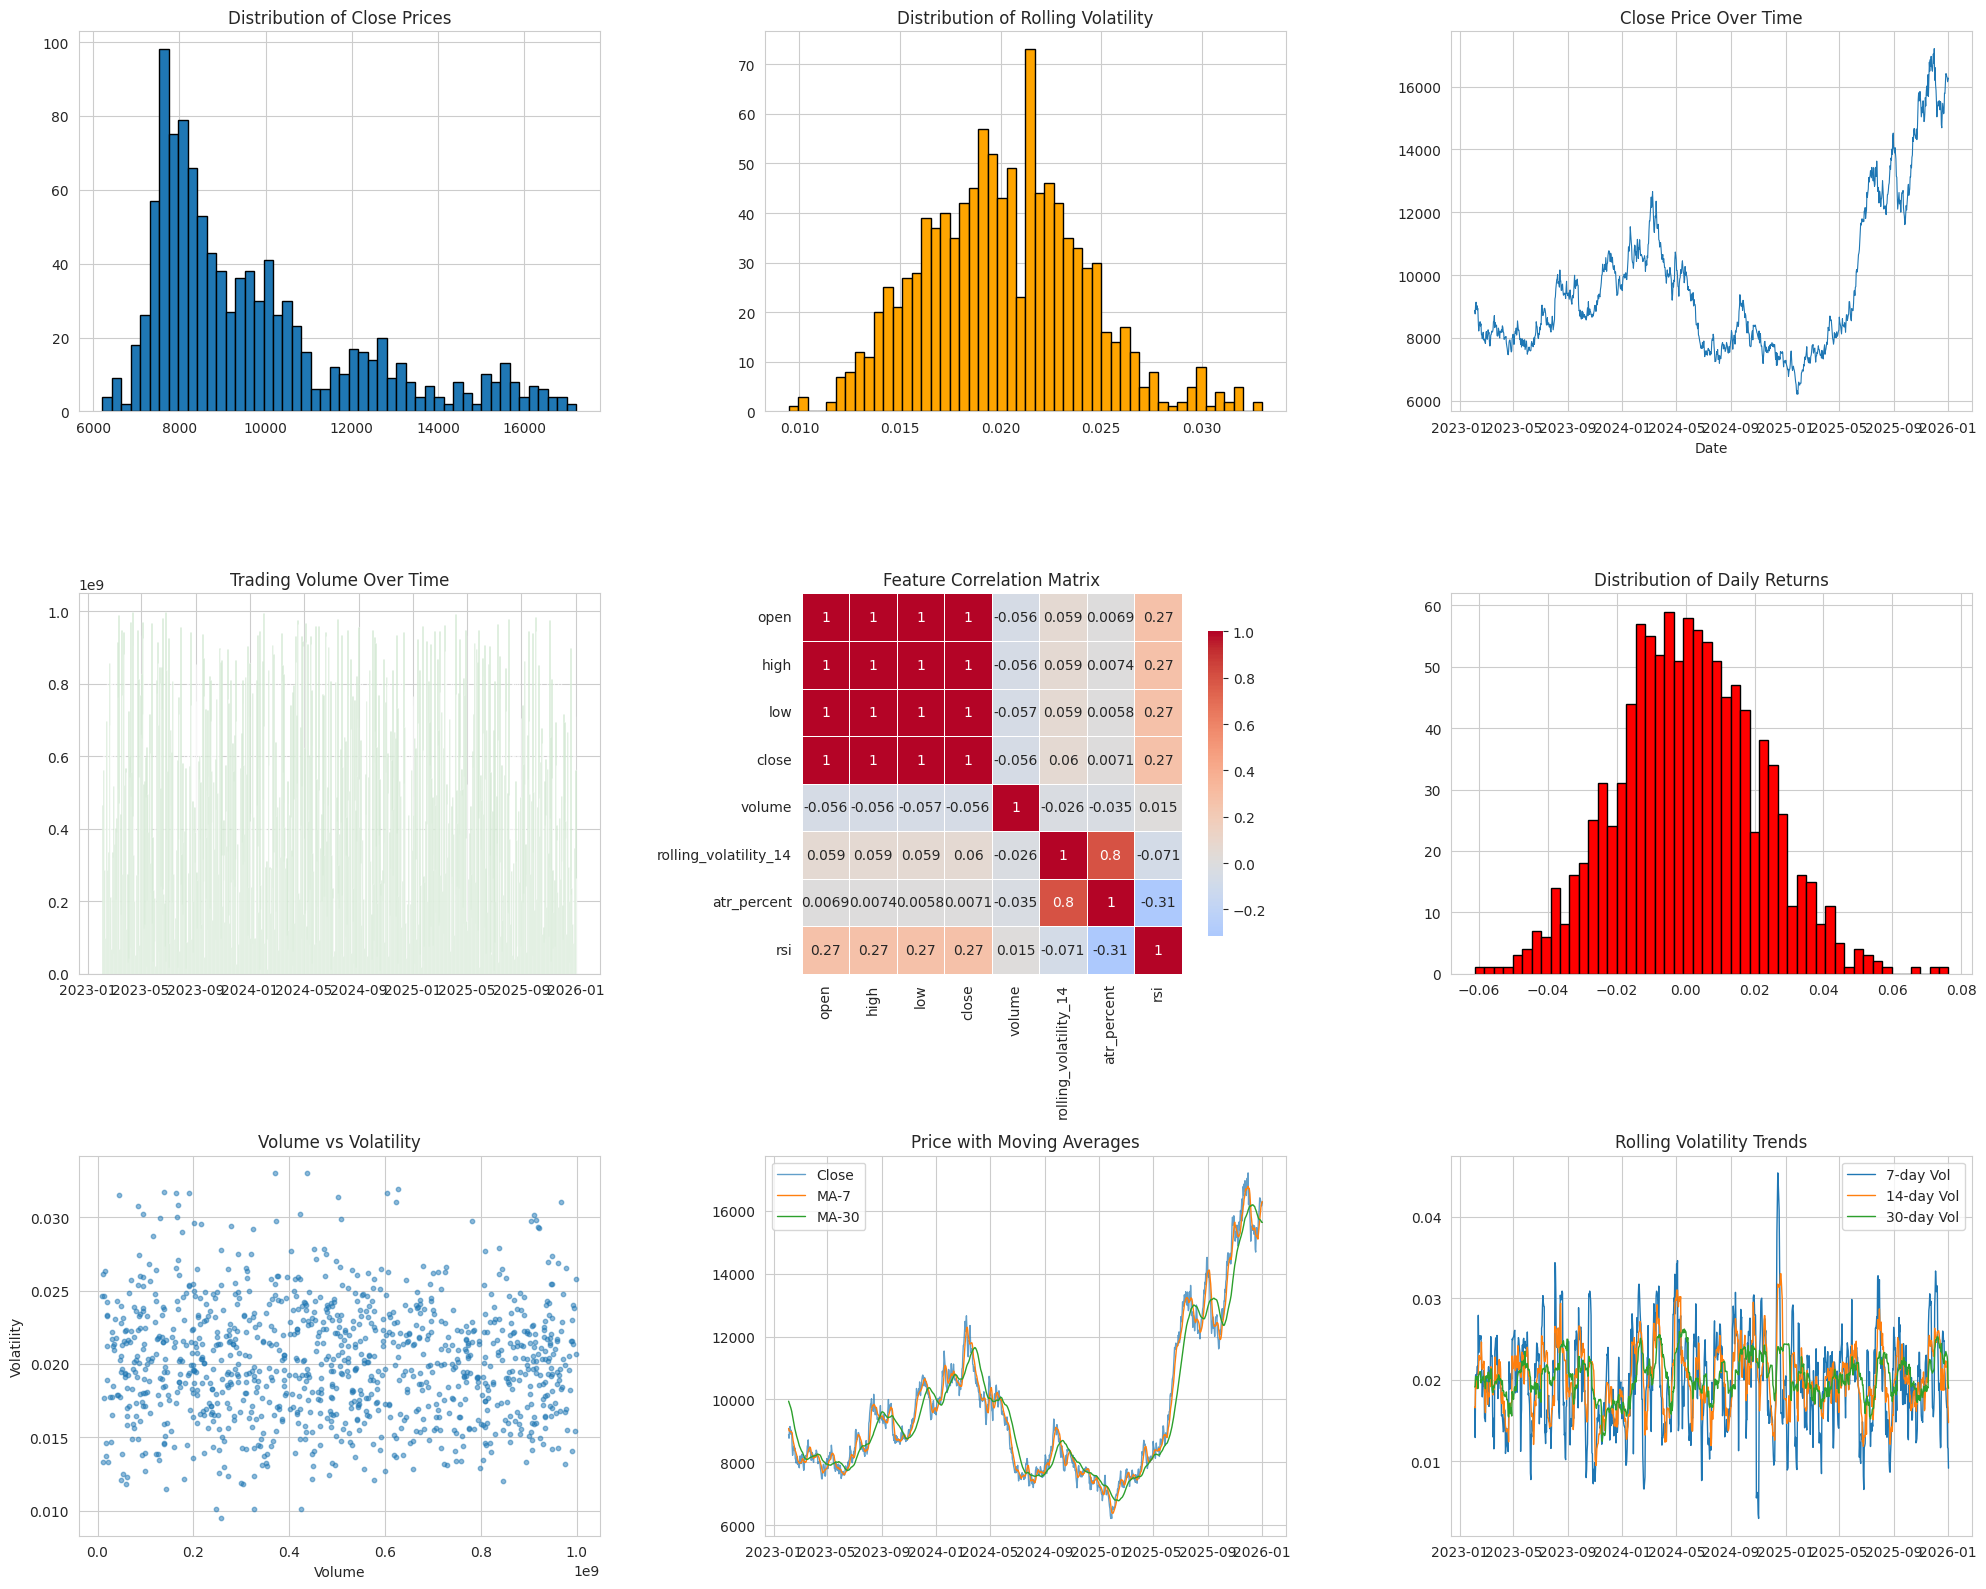


DATASET STATISTICS
               open          high           low         close        volume  \
count   1064.000000   1064.000000   1064.000000   1064.000000  1.064000e+03   
mean    9685.361375   9765.139104   9605.075184   9684.356492  4.955858e+08   
std     2397.862613   2419.741688   2379.519819   2400.472491  2.852765e+08   
min     6166.574058   6240.250335   6106.076722   6213.230609  1.023859e+07   
25%     7902.456466   7970.108918   7829.917773   7896.687824  2.487003e+08   
50%     8849.221961   8932.339752   8800.772318   8865.516313  4.879261e+08   
75%    10634.694858  10724.469201  10524.537356  10616.888112  7.482047e+08   
max    17102.263281  17232.970726  16990.022381  17206.876041  9.992152e+08   

       rolling_volatility_14  
count            1064.000000  
mean                0.020159  
std                 0.003965  
min                 0.009460  
25%                 0.017305  
50%                 0.020068  
75%                 0.022741  
max                 

AttributeError: 'LinearRegression' object has no attribute 'best_score_'

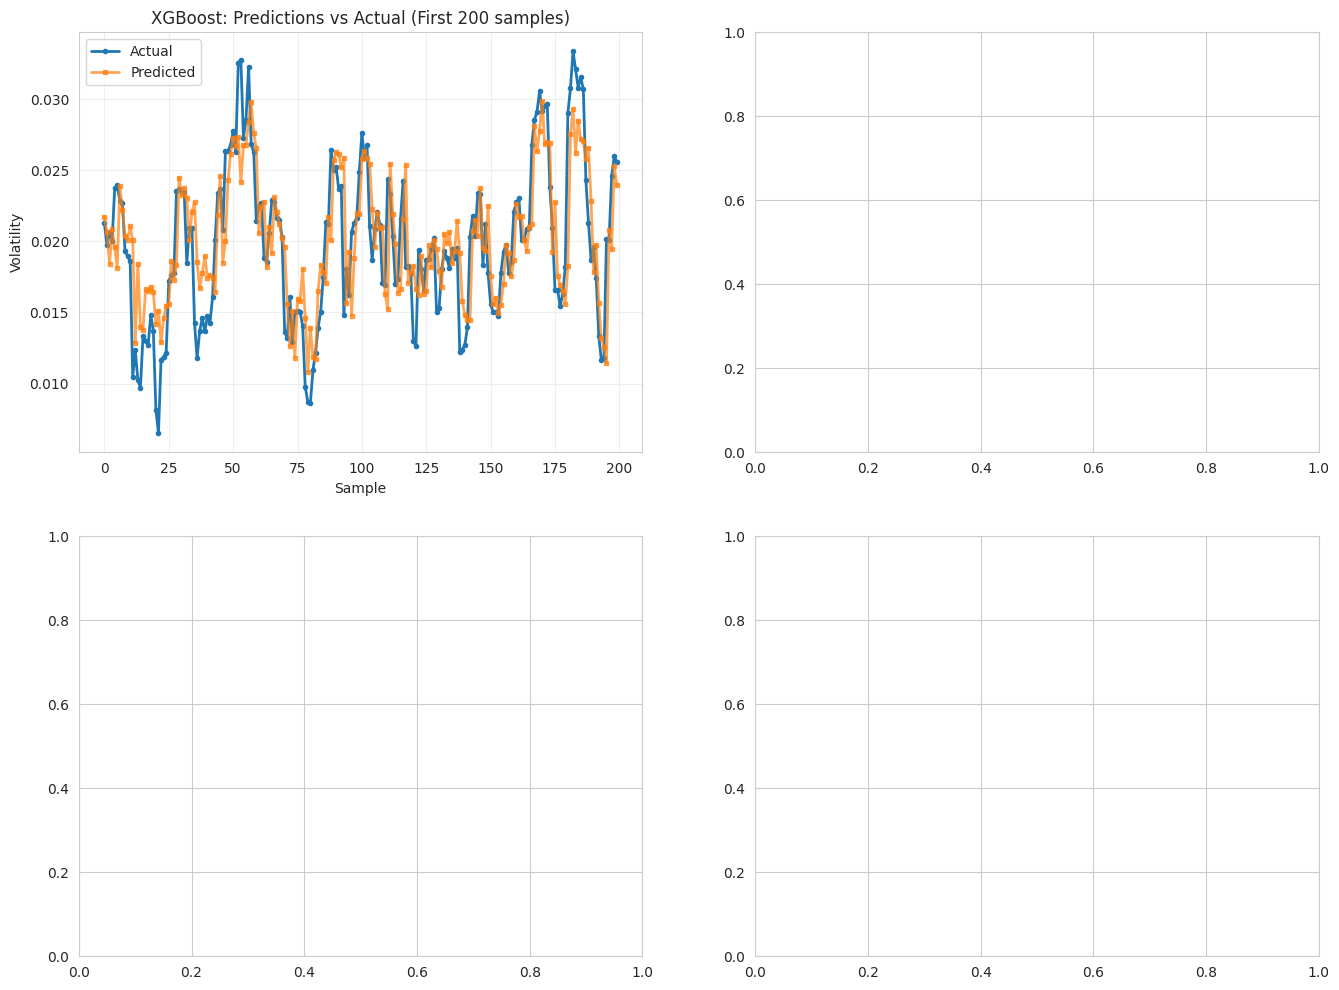

In [13]:
# main.py - Complete End-to-End Pipeline
def main():
    # 1. Load and preprocess data
    df = load_crypto_data('crypto_data.csv')
    df = handle_missing_values(df)
    df = clean_data(df)

    # 2. Feature engineering
    df = engineer_features(df)

    # 3. EDA
    perform_eda(df)

    # 4. Prepare data
    X_train, X_test, y_train, y_test, scaler, features = prepare_train_test_data(df)

    # 5. Train models
    models_dict, results_df, predictions_dict = train_multiple_models(
        X_train, X_test, y_train, y_test
    )

    # 6. Optimize best model
    best_model = optimize_best_model(X_train, X_test, y_train, y_test)

    # 7. Evaluate
    evaluate_and_visualize(models_dict, y_test, predictions_dict, results_df) # Pass results_df

    # 8. Save model
    save_model(best_model, scaler, features)

    # 9. Generate report
    print("\nProject completed successfully!")
    print("Deploy with: streamlit run app.py")

if __name__ == "__main__":
    main()

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Create dummy data for crypto_data.csv
# This is a placeholder to allow the pipeline to run without a real dataset.
# In a real scenario, you would replace this with actual data loading.

def create_dummy_crypto_data(filename='crypto_data.csv', num_days=365*3):
    dates = [datetime.now() - timedelta(days=x) for x in range(num_days, 0, -1)]

    np.random.seed(42)

    # Simulate price movements
    initial_price = 10000.0
    prices = [initial_price]
    for _ in range(1, num_days):
        change = np.random.normal(0, 0.02) # Daily price change
        prices.append(prices[-1] * (1 + change))

    prices = np.array(prices)

    # Ensure prices are always positive
    prices[prices <= 0] = 1 # Small positive value

    # Generate other features based on prices
    open_prices = prices * (1 + np.random.normal(0, 0.005, num_days))
    close_prices = prices * (1 + np.random.normal(0, 0.005, num_days))
    high_prices = np.maximum(open_prices, close_prices) * (1 + np.random.uniform(0.001, 0.01, num_days))
    low_prices = np.minimum(open_prices, close_prices) * (1 - np.random.uniform(0.001, 0.01, num_days))

    # Ensure low <= open/close <= high
    for i in range(num_days):
        temp_high = max(open_prices[i], close_prices[i])
        temp_low = min(open_prices[i], close_prices[i])
        high_prices[i] = max(high_prices[i], temp_high)
        low_prices[i] = min(low_prices[i], temp_low)

    volume = np.random.uniform(1e7, 1e9, num_days)
    market_cap = close_prices * np.random.uniform(1e6, 1e7, num_days) # Simplified market cap

    df = pd.DataFrame({
        'date': dates,
        'open': open_prices,
        'high': high_prices,
        'low': low_prices,
        'close': close_prices,
        'volume': volume,
        'market_cap': market_cap
    })

    df.to_csv(filename, index=False)
    print(f"Dummy '{filename}' created successfully with {num_days} days of data.")

create_dummy_crypto_data()

Dummy 'crypto_data.csv' created successfully with 1095 days of data.


Data Source: Use Kaggle's cryptocurrency dataset or APIs like CoinGecko/Binance

Best Model: XGBoost typically performs best for this task

Evaluation Metric: Use RMSE and R² score as primary metrics

Deployment: Streamlit provides the easiest interface for end-users

Documentation: Create visual diagrams for system architecture and data flow